<a href="https://colab.research.google.com/github/RoverLiu/AI_UAV/blob/master/MTRX5700.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTRX5700 - Implementing a neural network
**Goal:** Image classification on the CIFAR-10 dataset.

## Setup
###Initialize 
First we import the necessary python modules.  
Then we download the datasets. 

###Data split
In this example we are splitting the data into a **training** set on which to train the network and a **test** set on which to test the network. Ideally, in practice we should also have a **validation** set that we use during training to tune additional parameters. The test set should only be used once we *freeze* our network parameters.

###Custom Transforms
We then normalize the data to have a mean 0.5 and standard deviation 0.5 and convert image data to pytorch `tensors`.

In [ ]:
# import necessary python modules
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torchvision


# Define some custom transforms to apply to the image
custom_transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', 
                                        train=True,     # True for training set
                                        download=True, 
                                        transform=custom_transform)
testset = torchvision.datasets.CIFAR10(root='data', 
                                       train=False,    # False for test set
                                       download=True, 
                                       transform=custom_transform)

Files already downloaded and verified
Files already downloaded and verified


## Define Dataloaders
A `Dataloader` is a class defined in pytorch to load data efficiently.
We will define one loader for the training data and one for the test data.

### Batch size
As the dataset is large, it cannot be loaded all at once in memory. It is also inefficient to process just one image at once. Hence we divide the dataset into batches. The size of a batch is called the `batch_size`.

### Shuffling
We also shuffle the training data so that a there is a high chance that each batch contains samples from multiple classes.
As we are only using the test data for inference, we need not shuffle it.

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=8,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False)


## Understanding the dataset

The CIFAR-10 dataset contains objects of 10 classes.
We investigate the dataset and print out several useful information.


Number of training samples is 50000
Number of test samples is 10000
Batch size is 8
Size of each image is torch.Size([3, 32, 32])
The labels in this batch are: tensor([4, 6, 6, 4, 6, 9, 0, 2])
These correspond to the classes: deer, frog, frog, deer


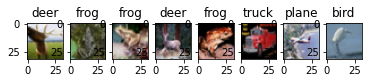

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

# print number of samples
print("Number of training samples is {}".format(len(trainset)))
print("Number of test samples is {}".format(len(testset)))

# iterate through the training set print useful information
dataiter = iter(trainloader)
images, labels = dataiter.next()    # this gather one batch of data

print("Batch size is {}".format(len(images)))
print("Size of each image is {}".format(images[0].shape))

print("The labels in this batch are: {}".format(labels))
print("These correspond to the classes: {}, {}, {}, {}".format(
    classes[labels[0]], classes[labels[1]],
    classes[labels[2]], classes[labels[3]]))

# plot images of the batch
fig, ax = plt.subplots(1, len(images))
for id, image in enumerate(images):
  # convert tensor back to numpy array for visualization
  ax[id].imshow((image / 2 + 0.5).numpy().transpose(1,2,0))
  ax[id].set_title(classes[labels[id]])

## Defining the network
We define our neural network to be composed of a convolutional layer followed ReLU activation, followed by downsampling using max pooling, followed by another convolutional layer and ReLU activation, and then three fully connected layers with ReLU activations.

In [ ]:
class Network(nn.Module):
  """The class that defines the neural network."""
  def __init__(self):
    """Define the layers of the network."""
    self.output_size = 10   # 10 classes

    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)             # 2D convolution
    self.pool = nn.MaxPool2d(2, 2)              # max pooling
    self.conv2 = nn.Conv2d(6, 16, 5)            # 2D convolution
    self.fc1 = nn.Linear(16 * 5 * 5, 120)       # Fully connected layer
    self.fc2 = nn.Linear(120, 84)               # Fully connected layer
    self.fc3 = nn.Linear(84, self.output_size)  # Fully connected layer

  def forward(self, x):
    """Define the forward pass."""
    x = self.pool(functional.relu(self.conv1(x)))
    x = self.pool(functional.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = functional.relu(self.fc1(x))
    x = functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    
net = Network()


## Defining the loss function and optimizar
The loss function that we are using here the **cross entropy loss**, which is ideal for multi-class classification tasks.

We are using the stochastic gradient descent with momentum as the optimizer.
This is a variant of gradient descent with a formulation that helps avoid local minima or saddle points.

We are setting initial `learning rate` to 0.001 and `momemtum` to 0.9. These values can be tuned as appropriate.



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training loop
We are now set to perform training.

Each pass over the entire dataset is called an **epoch**.


In [ ]:
for epoch in range(5):    # we are using 5 epochs. Typically 100-200
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # Perform forward pass and predict labels
    predicted_labels = net(inputs)

    # Calculate loss
    loss = criterion(predicted_labels, labels)
    
    # Perform back propagation and compute gradients
    loss.backward()
    
    # Take a step and update the parameters of the network
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print('Epoch: %d, %5d loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training.')
torch.save(net.state_dict(), "data/cifar_trained.pth")
print('Saved model parameters to disk.')

Epoch: 1,  2000 loss: 2.146
Epoch: 1,  4000 loss: 1.801
Epoch: 1,  6000 loss: 1.583
Epoch: 2,  2000 loss: 1.466
Epoch: 2,  4000 loss: 1.428
Epoch: 2,  6000 loss: 1.371
Epoch: 3,  2000 loss: 1.293
Epoch: 3,  4000 loss: 1.291
Epoch: 3,  6000 loss: 1.232
Epoch: 4,  2000 loss: 1.170
Epoch: 4,  4000 loss: 1.183
Epoch: 4,  6000 loss: 1.174
Epoch: 5,  2000 loss: 1.100
Epoch: 5,  4000 loss: 1.105
Epoch: 5,  6000 loss: 1.101
Finished Training.
Saved model parameters to disk.


## Testing
Load data similar to how we did earlier.  
Use the trained network to predict labels.

### Class Probabilities
We would like to interpret the predictions as a set of probability distributions over the classes. This can be achieved by using the softmax function. The softmax function normalizes outputs as follows.

$\sigma(y)_i = \frac{e^{y_i}}{\sum_j{e^{y_j}}}$

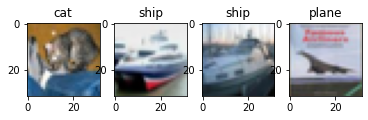

True label cat, Predicted label cat - 0.4100
True label car, Predicted label car - 0.9410
True label car, Predicted label car - 0.6298
True label plane, Predicted label plane - 0.8045


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, ax = plt.subplots(1, len(images))
for id, image in enumerate(images):
  # convert tensor back to numpy array for visualization
  ax[id].imshow((image / 2 + 0.5).numpy().transpose(1,2,0))
  ax[id].set_title(classes[labels[id]])
plt.show()

# Predict the output using the trained neural network
outputs = net(images)

# Normalize the outputs using the Softmax function so that
# we can interpret it as a probability distribution.
sm = nn.Softmax(dim=1)      
sm_outputs = sm(outputs)

# For each output the prediction with the highest probability
# is the predicted label
probs, index = torch.max(sm_outputs, dim=1)
for p, i in zip(probs, index):
    print('True label {0}, Predicted label {0} - {1:.4f}'.format(classes[i], p))